# Catenary

$$
\min_{u, \lambda} F(u; \lambda) = \int_{-1}^1 u \sqrt{1 + (\epsilon u')^2} \, dx - 
\lambda \int_{-1}^1 \left[\frac{\ell}{2} - \sqrt{1 + (\epsilon u')^2} \right] \, dx
$$

$$
\frac{ds}{dx} = \sqrt{1 + (\epsilon u')^2} \implies F(u; \lambda) = \int_{-1}^1 u(x) \frac{ds}{dx}(x) - 
\lambda \left[\frac{\ell}{2} - \frac{ds}{dx}(x) \right] \, dx
$$

2.597033699203166e-12


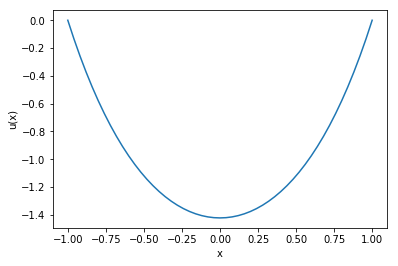

In [3]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt

# parameters
ℓ = Constant(3)
ϵ = Constant(0.5)

# mesh
N = 50
mesh = IntervalMesh(N, -1, 1)

# build function space for F
u_fe = FiniteElement("CG", mesh.ufl_cell(), 1)   # space for u
λ_fe = FiniteElement("R", mesh.ufl_cell(), 0)   # λ in R
V = FunctionSpace(mesh, MixedElement([u_fe, λ_fe]))  # C[-1, 1] x R

# get my functional
f = Function(V)

# split up u and λ
u, λ = split(f)

# build the functional
dsdx = sqrt(1 + (ϵ * u.dx(0)**2))   # x**2 = x^2

# constraint
constraint = (ℓ / Constant(2) - dsdx)
F = (u * dsdx - λ * constraint) * dx
# total derivative
dF = derivative(F, f)
# second derivative
d2F = derivative(dF, f)


# boundary condition
bc = DirichletBC(V.sub(0), Constant(0), "on_boundary")    # 0'th subspace of V is C[-1, 1]


# initial guess
init_val = 1.0
f.interpolate(Expression(("amp*(x[0]+1)*(x[0]-1)","0"),degree=2,amp=init_val))

# build the nonlinear problem
problem = NonlinearVariationalProblem(dF, f, bc, d2F)

# build a solver
solver = NonlinearVariationalSolver(problem)
solver.parameters['nonlinear_solver'] = 'snes'
solver.parameters['snes_solver']['line_search'] = 'bt'
solver.parameters['snes_solver']['maximum_iterations'] = 1000

# solve
solver.solve()

# verify the solution satisfies the constraint:
print(assemble(dsdx * dx) - float(ℓ))

# plot result
plot(u)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.show()